In [1]:
from numpy import *


def loadSimpData():
    datMat = matrix([[1., 2.1],
                     [2., 1.1],
                     [1.3, 1.],
                     [1., 1.],
                     [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels


def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):  # just classify the data
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray


def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m, 1)))
    minError = inf  # init error sum, to +infinity
    for i in range(n):  # loop over all dimensions
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1, int(numSteps)+1):  # loop over all range in current dimension
            for inequal in ['lt', 'gt']:  # go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(
                    dataMatrix, i, threshVal, inequal)  # call stump classify wi
                errArr = mat(ones((m, 1)))
                errArr[predictedVals == labelMat] = 0

                weightedError = D.T*errArr  # calc total error multiplied by D
                # print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" %
                if any(weightedError < minError):
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst


def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m, 1))/m)  # init D to all equal
    aggClassEst = mat(zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(
            dataArr, classLabels, D)  # build Stump
        # print "D:",D.T
        # calc alpha, throw in max(error,eps) to
        alpha = float(0.5*log((1.0-error)/max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)  # store Stump Params in Array
        # print "classEst: ",classEst.T
        # exponent for D calc, getting messy
        expon = multiply(-1*alpha*mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))  # Calc New D for next iteration
        D = D/D.sum()
        # calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        # print "aggClassEst: ",aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) !=
                             mat(classLabels).T, ones((m, 1)))
        errorRate = aggErrors.sum()/m
        print("total error: ", errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

In [2]:
dataMat, classLabels =loadSimpData()

In [23]:
D = mat(ones((5,2))/5)
D

matrix([[0.2, 0.2],
        [0.2, 0.2],
        [0.2, 0.2],
        [0.2, 0.2],
        [0.2, 0.2]])

In [24]:
buildStump(dataMat, classLabels, D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2],
         [0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [16]:
classifierArray, aggClassEst = adaBoostTrainDS(dataMat, classLabels, 9)

total error:  0.2
total error:  0.2
total error:  0.0


In [20]:
import matplotlib.pyplot as plt

def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)  # cursor
    ySum = 0.0  # variable to calculate AUC
    numPosClas = sum(array(classLabels) == 1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()  # get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    # loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        # draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("the Area Under the Curve is: ", ySum*xStep)

In [10]:
classifierArray

([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
  {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
  {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

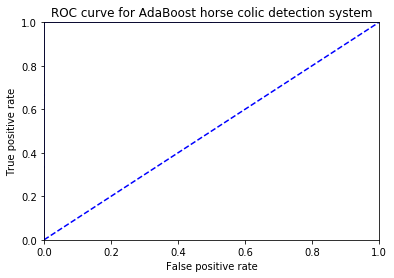

the Area Under the Curve is:  1.0


In [17]:
plotROC(aggClassEst.T,classLabels)

In [18]:
aggClassEst

matrix([[ 1.17568763],
        [ 2.56198199],
        [-0.77022252],
        [-0.77022252],
        [ 0.61607184]])

In [19]:
classLabels

[1.0, 1.0, -1.0, -1.0, 1.0]